# Running Your First Models

In this notebook, we demonstrate the basic use of UCLCHEM's python module by running a simple model and then using the analysis functions to examine the output.

In [2]:
import uclchem
import pandas as pd
import matplotlib.pyplot as plt

## A Simple Cloud

UCLCHEM's `cloud()` model is a spherical cloud of isothermal gas. We can keep a constant density or have it increase over time following a freefall equation. This model is generally useful whenever you want to model a homogeneous cloud of gas under constant conditions. For example, in the inner parts of a molecular cloud where Av $\gtrsim$ 10 there are very few depth dependent processes. You may wish to model the whole of this UV shielded portion of the cloud with a single `cloud()` model.

In [3]:
# set a parameter dictionary for phase 1 collapse model

outSpecies = "SO CO"
param_dict = {
    "switch": 0,#stop at finalTime
    "collapse": 1,#increase density in freefall
    "outSpecies": outSpecies, #species to return abundances for
    "initialDens": 1e2, #starting density
    "initialTemp": 10.0,#temperature of gas
    "finalDens": 1e6,#final density - collapse stops here
    "finalTime": 6.0e6, #final time
    "rout":0.1, #radius of cloud in pc
    "baseAv:":1.0, #visual extinction at cloud edge.
    "outputFile": "../examples/test-output/phase1-full.dat",#full UCLCHEM output
    "abundSaveFile": "../examples/test-output/startcollapse.dat",#save final abundances to file
}
success_flag, abunds = uclchem.cloud(param_dict)
print(success_flag)
print(abunds)

0
[1.95585829e-15 3.99833913e-13]


## Checking the output
The output file is just a simple csv with some header rows, UCLCHEM has a utility function to read that file into a pandas dataframe. 



In [3]:
phase1_df=uclchem.read_output_file("../examples/test-output/phase1-full.dat")
phase1_df.head()

,Time,Density,gasTemp,av,point,H,#H,H+,@H,H2,...,HSO2+,H2S2+,H2S2,#H2S2,@H2S2,E-,BULK,SURFACE,zeta,radfield
0,0.000000e+00,100100.0,10.0,11.644,1,1.470530e-08,3.282830e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
1,1.000000e-07,100100.0,10.0,11.653,1,1.470530e-08,3.282830e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
2,1.000000e-06,100100.0,10.0,11.653,1,1.470530e-08,3.282820e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
3,1.000000e-05,100100.0,10.0,11.653,1,1.470530e-08,3.282690e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
4,1.000000e-04,100100.0,10.0,11.653,1,1.470530e-08,3.281360e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190340e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0


We can also test whether the model run went well by checking for element conservation. We do this because integrator errors often show up as a failure to conserve elemental abundances. 

We can use `check_element_conservation()` to test whether we conserve elements in this run. The output values are the difference in the starting and final abundances of each element as a percentage of the original abundance. If these are too high, you could consider changing the `reltol` and `abstol` parameters that control the integrator accuracy. These are tolerances, smaller values lead to smaller errors and, usually, longer integration times. The default values were chosen by running a large grid of models and choosing the tolerances with the lowest average run time from those that conserved elements well and rarely failed. Despite this, there are no one-size-fits-all perfect tolerances and you may run into issues with different networks or models.

In [4]:
conservation=uclchem.check_element_conservation(phase1_df)
print(conservation)

{'H': '0.005%', 'N': '0.016%', 'C': '0.025%', 'O': '0.488%'}


## Plotting Results
Finally, you will want to plot your results. This can be done with any plotting library but UCLCHEM does provide a few functions to make quick plots. Note the use of $ symbols in the species list below, this gets the total ice abundance of a species. For two phase models, this is just the surface abudance but for three phase it is the sum of surface and bulk.

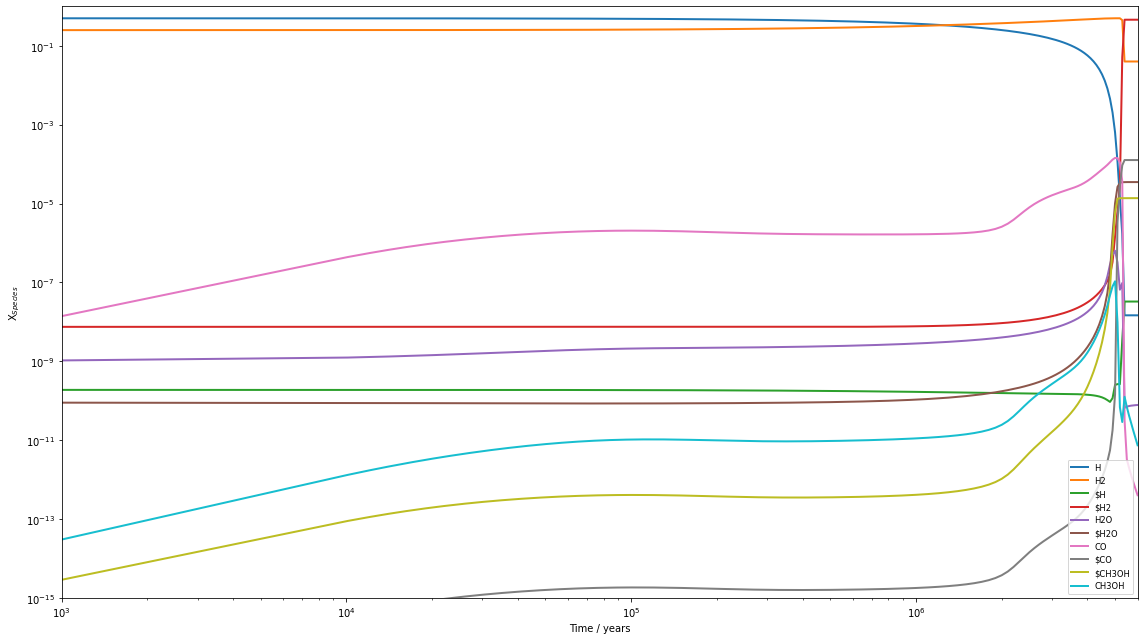

In [5]:
species=["H","H2","$H","$H2","H2O","$H2O","CO","$CO","$CH3OH","CH3OH"]
fig,ax=uclchem.create_abundance_plot(phase1_df,species)
ax=ax.set(xscale="log",ylim=(1e-15,1),xlim=(1e3,6e6))